# Training Lab41's monaural source separation model

This notebook contains a detailed example of how to train Lab41's source separation model.  Filepaths to load training data must be filled in to run this notebook.

In [1]:
# Generic imports
import sys
import time

import numpy as np
import tensorflow as tf

# Plotting imports
import IPython
from IPython.display import Audio
from matplotlib import pyplot as plt
fig_size = [0,0]
fig_size[0] = 8
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

# Import Lab41's separation model
from magnolia.dnnseparate.L41model import L41Model

# Import utilities for using the model
from magnolia.utils.clustering_utils import clustering_separate, get_cluster_masks, process_signal
from magnolia.iterate.supervised_iterator import SupervisedIterator, SupervisedMixer
from magnolia.iterate.hdf5_iterator import SplitsIterator

### Hyperparameters
    numsources  : Number of sources used in training mixes
    batchsize   : Number of examples per batch used in training
    datashape   : (Time, Frequency) shape of the examples within each batch

In [ ]:
numsources = 2
batchsize = 256
fft_size = 512
datashape = (40, fft_size//2 + 1)

### Set up data I/O

For training, only the training dataset is needed.  The other two datasets can be used for evaluation.  The (training set, or in set) speaker keys have been separated according to speaker gender.

In [ ]:
libritrain = "Path to training dataset"

with open('Magnolia/data/librispeech/authors/train-clean-100-F.txt','r') as speakers:
    keys = speakers.read().splitlines()
    speaker_keys = keys[:]
    in_set_F = keys[:]
    
with open('Magnolia/data/librispeech/authors/train-clean-100-M.txt','r') as speakers:
    keys = speakers.read().splitlines()
    speaker_keys += keys
    in_set_M = keys[:]

### Create an mixer that iterates over examples from the training set. 

SplitsIterator handles (deterministically) splitting the training set into three partitions.  80% of the training data is used to train the model, 10% is used to evaluate the training progress on unseen examples, and the last 10% is reserved to evaluate the performance of the model on unseen examples from speakers in the training set.

SupervisedMixer handles the mixing of training examples. It outputs the model input (X), the output labels (Y) and the speakerIDs (I) of the speakers who are loudest in each time frequency bin.  Y must be reshaped and transposed so that it has shape (batchsize,time,frequency,numspeakers).

Scaling of the mixtures to create input batches for the model is done here as well.



In [ ]:
# Create the splits iterator
siterator = SplitsIterator([0.8,0.1,0.1], libritrain, speaker_keys=speaker_keys, shape=datashape, return_key=True)
siterator.set_split(0)

# Create the data mixer
mixer = SupervisedMixer([siterator,siterator], shape=datashape, 
                        mix_method='add', diffseed=True)

# Generate a sample batch of training data
X, Y, I = mixer.get_batch(batchsize, out_TF=None)
Y = Y.reshape(batchsize,2,datashape[0],datashape[1])
Y = Y.transpose([0,2,3,1])

# Scale the model inputs
X = np.sqrt(X)
X = (X - X.min())/(X.max() - X.min())

### Generate some validation data
To generate a batch from the validation split of the training dataset, the splits iterator can have the split set to the validation split and the mixer can be used as before.  

In [ ]:
# Set the current split to the validation split
siterator.set_split(1)

# Generate a batch of validation data
Xdv, Ydv, Idv = mixer.get_batch(batchsize, out_TF=None)
Ydv = Ydv.reshape(batchsize,2,datashape[0],datashape[1])
Ydv = Ydv.transpose(0,2,3,1)

# Scale the model inputs
Xinv = np.sqrt(Xdv)
Xinv = (Xinv - Xinv.min())/(Xinv.max() - Xinv.min())

# Set the split back to the training split
siterator.set_split(0)

### Create an instance of Lab41's model

Here an untrained model instance is created, and its variables are initialized

In [ ]:
model = L41Model(nonlinearity='tanh', normalize='False')
model.initialize()

### Variables needed to track the training progress of the model

During training, the number of iterations (number of processed batches) is tracked, along with the mean cost on examples from the training data and from the validation data.  The last iteration that the model was saved on can also be tracked.

In [ ]:
iterations = []
costs = []

t_costs = []
v_costs = []

last_saved = 0

### Training loop

Here the model is iteratively trained on batches generated by the mixer.  The model is saved every time the validation cost reaches a new minimum value.  The training can be configured to stop if the model has not been saved after a specified number of iterations have elapsed since the previous save.  Plots of the training cost and the validation set are created as well.

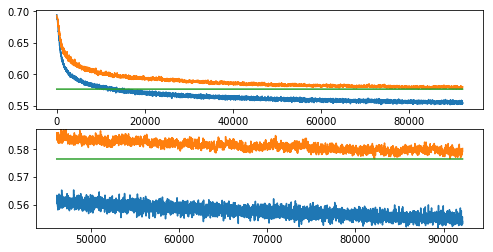

Cost on iteration 92160 is 0.580256
Last saved 10010 iterations ago.
Done!


In [558]:
# Number of iterations to train for (should be large)
num_iterations = 1000000
# Threshold for stopping if the model hasn't improved for this many consecutive iterations
stop_threshold = 10000

# Find the number of iterations already elapsed (Useful for resuming training)
if len(iterations) == 0:
    start = 0
else:
    start = iterations[-1]

# Ensure that the iterator is set to iterate over the training split
siterator.set_split(0)

# Iterate over training batches
for i in range(num_iterations):
    
    # Generate a batch of training data
    Xdata, Ydata, Idata = mixer.get_batch(batchsize, out_TF=None)
    Ydata = Ydata.reshape(batchsize,2,datashape[0],datashape[1])
    Ydata = Ydata.transpose(0,2,3,1)
    
    # Scale the inputs
    Xin = np.sqrt(np.abs(Xdata))
    Xin = (Xin - Xin.min())/(Xin.max() - Xin.min())
    
    # Train the model on one batch and get the cost
    c = model.train_on_batch(Xin,Ydata,Idata)

    # Store the training cost
    costs.append(c)
    
    # Every 10 batches, evaluate the model on the validation data and plot the cost curves
    if (i+1) % 10 == 0:
        IPython.display.clear_output(wait=True)
        
        # Get the cost on the validation batch
        c_v = model.get_cost(Xinv, Ydv, Idv)
        
        # Check if the validation cost is below the minimum validation cost, and if so, save it.
        if if len(v_costs)>0 and c_v < min(v_costs) and len(iterations) > 0:
            print("Saving the model because c_v is", min(v_costs) - c_v, "below the old min.")
            
            # Save the model to the specified path
            model.save("Path to saved model")
            
            # Record the iteraion that the model was last saved on
            last_saved = iterations[-1]
        
        # Store the training cost and the validation cost
        t_costs.append(np.mean(costs))
        v_costs.append(c_v)
        
        # Store the current iteration number
        iterations.append(i + 1 + start)
        
        # Compute scale quantities for plotting
        length = len(iterations)
        cutoff = int(0.5*length)
        lowline = [min(v_costs)]*len(iterations)
        
        # Generate the plots and show them
        f, (ax1, ax2) = plt.subplots(2,1)
        
        ax1.plot(iterations,t_costs)
        ax1.plot(iterations,v_costs)
        ax1.plot(iterations,lowline)
        
        y_u = max(max(t_costs[cutoff:]),max(v_costs[cutoff:]))
        y_l = min(min(t_costs[cutoff:]),min(v_costs[cutoff:]))
        
        ax2.set_ylim(y_l,y_u)
        
        ax2.plot(iterations[cutoff:], t_costs[cutoff:])
        ax2.plot(iterations[cutoff:], v_costs[cutoff:])
        ax2.plot(iterations[cutoff:], lowline[cutoff:])
        plt.show()
        
        print("Cost on iteration", iterations[-1], "is", c_v)
        print("Last saved",iterations[-1]-last_saved,"iterations ago.")
        
        # Reset the cost over the last 10 iterations
        costs = []
        
        # Stop training if the number of iterations since the last save point exceeds the threshold
        if iterations[-1]-last_saved > stop_threshold:
            print("Done!")
            break